#  image generating GANs - an exploration #

The aim of this competition is to generate 7000 to 10000 256x256 pixel images of monet paintings by use of a GAN - a Generative Adversarial Network.<br>
The idea of a GAN is simple; construct a network where one part is a generator which is to generate images that resemble the training images by use of sampling from a latent space (a vector space). The other part of the GAN is a discriminator with the aim of identifying if images input to it are real (training images) or fake (generated images).<br>
When this is set up the two parts play a constant ping-pong where the generator is generating a batch of images, these images are then combined with a batch of training images and fed into the discriminator, both to train the discriminator and in order to provide feedback to the generator wether or not the generated images are looking like real images. The generator is then adjusted so that, at least in theory, the images generated become more and more like the training images.<br>

I initially started out with something based on this:<br>
https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0<br>

Later I moved to other configurations, greatly helped by the hints here: https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9 but ultimately the custom GAN model simply did not perform well. GANs are difficult to train because they are constantly out of balance, if the discriminator gets too good then the generator learns nothing and if the generator gets too good then the discriminator ends up giving up. I tried many different network configurations (kernel sizes, number of filters, batch normalization, dropout/no dropout, activation functions etc) and I tried reversing the labels which is claimed to work well for training, as well as label smoothing where instead of 0 and 1 in the classes a small amount of noise is added to the labels in order to prevent the discriminator to lock the training process. Nothing made a great difference.

So in the end I turned my attention to a great library called lightweight-gan which works very well.

https://github.com/lucidrains/lightweight-gan<br>

### EDA ###

Before we dig into the model construction we need to know a bit more about the data we have available.<br>
There are two folders in the data provided: monet_jpg, containing 300 images of monet paintings and photo_jpg containing just over 7000 real images of landscapes. The latter folder is probably intended as input data to generative models, but this is not needed for our GAN.

First, let us take a look at one of the paintings.

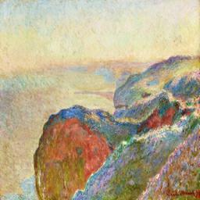

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Image.open('/kaggle/input/gan-getting-started/monet_jpg/000c1e3bff.jpg').resize((200, 200))

And below a crop where we can see the specific style.

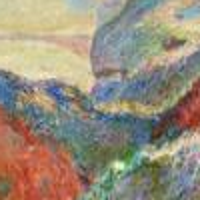

In [2]:
Image.open('/kaggle/input/gan-getting-started/monet_jpg/000c1e3bff.jpg').crop((100,100,200,200)).resize((200, 200))

In the histogram below (one for red colour, one for green color and one for blue) we can see that there are pretty narrow bands of specific intensities, wher most intensities are completely missing from the image above.

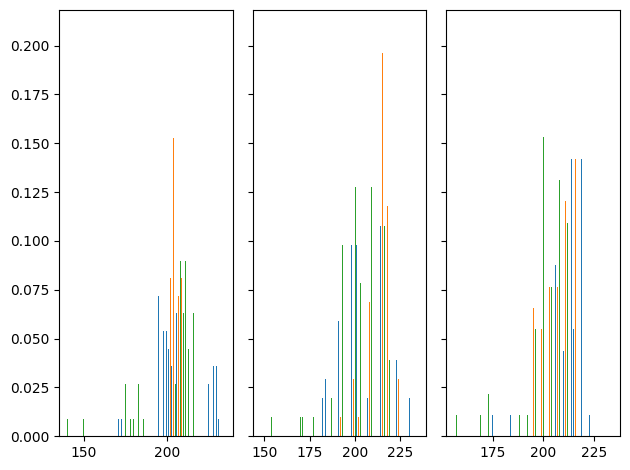

In [3]:
img = np.asarray(Image.open('/kaggle/input/gan-getting-started/monet_jpg/000c1e3bff.jpg').resize((300, 300)))

n_bins = 256

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

axs[0].hist(img[0], bins=n_bins, density=True)
axs[1].hist(img[1], bins=n_bins, density=True)
axs[2].hist(img[2], bins=n_bins, density=True)

plt.show()

Another Monet painting:

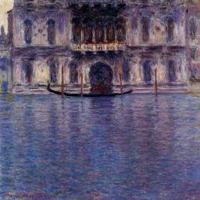

In [4]:
Image.open('/kaggle/input/gan-getting-started/monet_jpg/05b493ff42.jpg').resize((200, 200))

Zooming in we can see the same style that Monet is famous for.

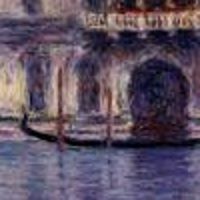

In [5]:
Image.open('/kaggle/input/gan-getting-started/monet_jpg/05b493ff42.jpg').crop((50,50,150,150)).resize((200, 200))

And on the histograms we can see the same lumping of intensities as we did before.

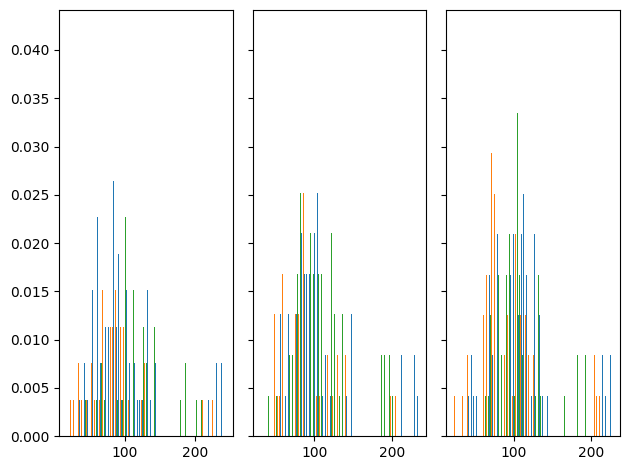

In [6]:
img = np.asarray(Image.open('/kaggle/input/gan-getting-started/monet_jpg/05b493ff42.jpg').resize((300, 300)))

n_bins = 256

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

axs[0].hist(img[0], bins=n_bins, density=True)
axs[1].hist(img[1], bins=n_bins, density=True)
axs[2].hist(img[2], bins=n_bins, density=True)

plt.show()

Let us turn our attention to one of the real landscape photos instead.

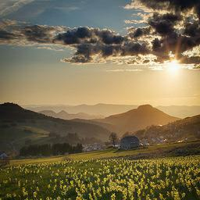

In [7]:
Image.open('/kaggle/input/gan-getting-started/photo_jpg/00068bc07f.jpg').resize((200, 200))

And obviously, zooming in we see no brush strokes or color blending. Just details and JPEG compression artifacts.

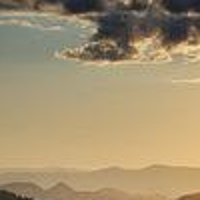

In [8]:
Image.open('/kaggle/input/gan-getting-started/photo_jpg/00068bc07f.jpg').crop((50,50,150,150)).resize((200, 200))

And if we take a look at the histograms we can see that the color intensities are now more evenly spread out.

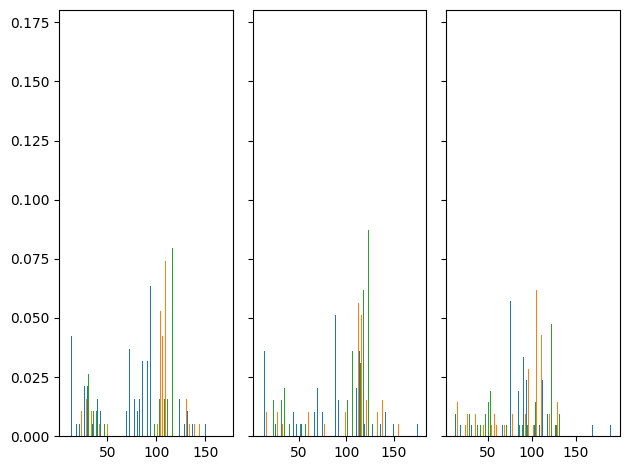

In [9]:
img = np.asarray(Image.open('/kaggle/input/gan-getting-started/photo_jpg/00068bc07f.jpg').resize((300, 300)))

n_bins = 256

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

axs[0].hist(img[0], bins=n_bins, density=True)
axs[1].hist(img[1], bins=n_bins, density=True)
axs[2].hist(img[2], bins=n_bins, density=True)

plt.show()

### Custom Keras model ###

Below is the GAN I experimented with. With small images (64x64 pixels or smaller) it occasionally works decently. With the larger 256x256 images required for this competition it does not work at all.

First import the required dependencies.

In [10]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import zipfile
import shutil

2024-05-22 05:23:29.535567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 05:23:29.535671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 05:23:29.674884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Define the generator. This is responsible for constructing an image from a vector of floats.
Multiple layers of transpose convolutions will gradually increase the generated image size (since strides is set to 2 the image will double in size at each convolution).

In [11]:
def generator():
    dropout_level = 0.15
    start_dim = int(image_dimension/8)
    activation_function = 'leaky_relu'
    momentum = 0.99
    num_filters = 128

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(start_dim*start_dim*num_filters, input_dim=latent_size, activation=None))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
    model.add(tf.keras.layers.Reshape((start_dim,start_dim, num_filters)))
    model.add(tf.keras.layers.Dropout(dropout_level))
    model.add(tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=kernel_size, strides=(2, 2), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
    model.add(tf.keras.layers.Dropout(dropout_level))
    model.add(tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=kernel_size, strides=(2, 2), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
    model.add(tf.keras.layers.Dropout(dropout_level))
    model.add(tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=kernel_size, strides=(2, 2), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
    model.add(tf.keras.layers.Dropout(dropout_level))
    model.add(tf.keras.layers.Conv2DTranspose(channels, kernel_size=kernel_size, strides=(1, 1), activation='tanh', padding='same'))

    return model

Define the discriminator. This is a normal binary classifier, input image data, output a binary classification.

In [12]:
def discriminator():
    dropout_level = 0.8
    activation_function = 'leaky_relu'
    momentum = 0.99
    num_filters = 128

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GaussianNoise(0.20))
    model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
    model.add(tf.keras.layers.RandomZoom(0.1))
    model.add(tf.keras.layers.RandomRotation(0.2))
    model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=kernel_size, strides=(2, 2), input_shape=(image_dimension, image_dimension, channels), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
    model.add(tf.keras.layers.Dropout(dropout_level))
    model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=kernel_size, strides=(2, 2), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
    model.add(tf.keras.layers.Dropout(dropout_level))
    model.add(tf.keras.layers.Conv2D(num_filters, kernel_size=kernel_size, strides=(2, 2), activation=activation_function, padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=momentum))
    model.add(tf.keras.layers.Dropout(dropout_level))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(30, activation=activation_function))
    model.add(tf.keras.layers.Dropout(dropout_level))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

Concatenate the generator and the discriminator into the adversarial model. Now we can input a vector from the latent space sampling and output a class. This is what allows us to train the generator into being able to generate images.

In [13]:
def define_adversarial_model(generator, discriminator):
    model = tf.keras.models.Sequential()

    model.add(generator)
    model.add(discriminator)

    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=1, weight_decay=0.03)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                      metrics=['accuracy'])

    return model

Set layers as trainable or not trainable. I have used this to turn off the discriminator layers in the adversarial model when training the generator, but to limited effect.

In [14]:
def set_trainable(model, on_off):
    for layer in model.layers:
        layer.trainable = on_off

Load training images. Originally I read each batch from the main loop while training but eventually I switched to loading all required training images into memory before starting training to speed up the training process.

In [15]:
def get_training_images(batch_size):
    all_images = np.zeros((batch_size, image_dimension, image_dimension, channels))
    
    for i in range(0, batch_size):
        all_images[i] = np.asarray(Image.open('/kaggle/input/gan-getting-started/monet_jpg/' + file_list[np.random.randint(len(file_list))])
                                           .resize((image_dimension, image_dimension)))[:,:,:3]
        
    return (all_images / 127) - 1

Define "constants".

image_dimension = Output dimension of image. Final output is image_dimension x image_dimension x 3 bytes<br>
batch_size = The number of real and fake images to include in each batch training of the model<br>
channels = The number of channels. 1 = black and white. 3 = color<br>
learning_rate = The learning rate. Always a balance between stable training and speed of training<br>
batchnorm_momentum = The momentum to use in batch normalization layers<br>
latent_size = The size of the latent space. Larger would mean more varied output but more difficult to map values. Smaller would mean less variation but easier training<br>

In [16]:
image_dimension = 256
batch_size = 8
filter_size = 4
depth = 10
channels = 3
learning_rate = 0.00001
batchnorm_momentum = 0.99
kernel_size = (7, 7)
latent_size = 100

Instantiate the models. Here I use Adam as optimizer but have also tried with stochastic gradient descent.

In [17]:
generator = generator()
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=1, weight_decay=0.03)
generator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

discriminator = discriminator()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1, weight_decay=0.03)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

adversarial_model = define_adversarial_model(generator, discriminator)

file_list = os.listdir(r"/kaggle/input/gan-getting-started/monet_jpg")

generator.summary()
discriminator.summary()
adversarial_model.summary()

monet_arr = get_training_images(300)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 131072)         │    13,238,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 131072)         │       524,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       802,944 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 128)  │       802,944 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 128)  │       802,944 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 256, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 3)    │        18,819 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,191,747 (61.77 MB)

 Trainable params: 15,928,835 (60.76 MB)

 Non-trainable params: 262,912 (1.00 MB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │    16,191,747 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,191,747 (61.77 MB)

 Trainable params: 15,928,835 (60.76 MB)

 Non-trainable params: 262,912 (1.00 MB)

Do the main training loop. Switch between training the discriminator on real and fake (generated from the generator) images and training the entire adversarial network (which will be training the generator).<br>
For every 50 loops do a check to see if the generator or the discriminator are getting too strong and causing an imbalance in the network. Ideally we would use these values to tweak the learning rates but I have not experimented with that.<br>
Also, for every 100 training loops, we generate 5 test images.<br>
Ideally we would run for much longer obviously but due to resource restrictions and a memory leak in the tensorflow version that is included in the Kaggle kernel package I only train it briefly.

In [18]:
for i in range(0, 150):
    discriminator_result = 0
    discriminator_X1 = generator(np.random.uniform(size=[batch_size, latent_size]), training=False)
    discriminator_X2 = np.zeros((batch_size, image_dimension, image_dimension, channels))

    for ii in range(0, batch_size):
        discriminator_X2[ii] = monet_arr[int(np.random.rand()*monet_arr.shape[0])]

    if i % 50 == 0:
        print('Mean prediction (fake)' + str(np.mean(discriminator(discriminator_X1, training=True))))
        print('Mean prediction (real)' + str(np.mean(discriminator(discriminator_X2, training=True))))
    combined_X = np.concatenate((discriminator_X1, discriminator_X2))
    combined_y = np.concatenate((np.zeros((batch_size, 1)) + (np.random.rand()*0.1+0.1), np.ones((batch_size, 1)) - (np.random.rand()*0.1+0.1)))
    discriminator.train_on_batch(x=combined_X, y=combined_y)

#    set_trainable(discriminator, False)
    adversarial_X = np.random.uniform(size=[batch_size, latent_size])
    adversarial_model.train_on_batch(adversarial_X, y=np.ones((batch_size, 1)))
#    set_trainable(discriminator, True)

    if i % 100 == 0:
        print('Batch number ' + str(i) + '. Saving model and generating test images..')
        test_img = np.asarray(generator(np.random.uniform(size=[20, latent_size]), training=False))
        for test in range(0, 10):
            img = ((test_img[test] + 1) * 127).astype(np.uint8).reshape(image_dimension, image_dimension, channels)
            Image.fromarray(img).save('test_image' + str(test) + '.jpeg')
#            generator.save('generator.keras')
            
#generator.save('generator.keras')
#discriminator.save('discriminator.keras')
#adversarial_model.save('adversarial_model.keras')

print('Done training')

Mean prediction (fake)0.4479733
Mean prediction (real)0.5099771


2024-05-22 05:23:48.454429: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch number 0. Saving model and generating test images..


2024-05-22 05:24:50.073516: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-22 05:25:50.312834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Mean prediction (fake)0.48796776
Mean prediction (real)0.47677276


2024-05-22 05:26:50.334815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-22 05:27:50.713500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Mean prediction (fake)0.53727317
Mean prediction (real)0.6600388
Batch number 100. Saving model and generating test images..


2024-05-22 05:28:50.964140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/sequential_1/dropout_1_2/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-22 05:29:51.257802: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-22 05:30:51.616874: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/sequential_1/dropout_1_2/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Done training


In [19]:
os.mkdir('./output_images')

for batch in range(0, 70):
    test_img = np.asarray(generator(np.random.uniform(size=[100, latent_size]), training=False))
    for test in range(0, 100):
        img = ((test_img[test] + 1) * 127).astype(np.uint8).reshape(image_dimension, image_dimension, channels)
        Image.fromarray(img).save('./output_images/monet' + str(test+batch*100) + '.jpeg')

shutil.make_archive('images', 'zip', './output_images/')

print('Done creating images')

Done creating images


### Lightweight GAN ###

Obviously an alternative to building a GAN from scratch is to use one of the very good libraries freely available. I chose to take a closer look at lightweight-gan which is fast and stable. In the past the only downside of this library I have noticed is that, under certain conditions, there appears to be some mode collapse. This results in the model producing the same image again and again. However since my custom model does not work very well at all, lightweight-gan is by far preferrable.
It only takes a few lines of code to train the network and to generate images:

In [20]:
#import lightweight-gan
#import os
#
#os.system('lightweight_gan --data /kaggle/input/gan-getting-started/monet_jpg --name test_run_lightweight --batch-size 32 --gradient-accumulate-every 4 --num-train-steps 10000 --image-size 256 --amp --aug-prob 0.1')
#os.command('lightweight_gan --name 20000 --load-from 20000 --generate')


### Conclusion / final remarks ###

It is an interesting challenge to create a successful GAN. I have spent a fair amount of time exploring various configurations of the custom GAN but my main problem remains that a GAN can be somewhat functional even though it is not working fully. You get generated content and in the case of images, if you look long enough it seems like there is useful content even if there is not. On top of that it is time consuming. Even with decent hardware it can take hours, or days for each trial run. Compared with the infinite design choices it can be a huge task to build a succesful GAN.

However, for future experimentation, I think I will want to look into how changing the size of the latent space reflects in the generated content. Also in retrospect I should have started with an extremely small image output and worked my way up from there as that would have saved time and effort.